# 朴素贝叶斯

朴素贝叶斯是基于贝叶斯定理与特征条件独立假设的分类方法。朴素贝叶斯法是典型的生成学习方法。
基本步骤：
- 基于条件独立假设的学习输入与输出的联合概率分布
- 基于此模型，对给定的输入x，利用贝叶斯定理求出后验概率最大的输出
下面是学习资料上的具体的展开： 


1．XY的联合概率分布P(X,Y)的得到
在训练数据估计$P(X|Y)$和$P(Y)$，得到XY的联合概率分布：

$$P(X,Y)＝P(Y)P(X|Y)$$

概率估计方法可以是极大似然估计或贝叶斯估计。
但是问题是如何得到这里的 $P(X|Y)$,
$$\begin{aligned} P(X&=x | Y=c_{k} )=P\left(X^{(1)}=x^{(1)}, \cdots, X^{(n)}=x^{(n)} | Y=c_{k}\right)  \end{aligned}$$
此条件概率分布会是具有指数级数量的参数，如果变量之间存在相关的话，即所有变量的组合，会是$N!.$

2．朴素贝叶斯法的基本假设是条件独立性，假设各个变量之间互相不相关，即特征之间是相互独立的

$$\begin{aligned} P(X&=x | Y=c_{k} )=P\left(X^{(1)}=x^{(1)}, \cdots, X^{(n)}=x^{(n)} | Y=c_{k}\right) \\ &=\prod_{j=1}^{n} P\left(X^{(j)}=x^{(j)} | Y=c_{k}\right) \end{aligned}$$


这是一个较强的假设。由于这一假设，模型包含的条件概率的数量大为减少，朴素贝叶斯法的学习与预测大为简化。因而朴素贝叶斯法高效，且易于实现。其缺点是分类的性能不一定很高。

3．朴素贝叶斯法利用贝叶斯定理与学到的联合概率模型进行分类预测。

$$P(Y | X)=\frac{P(X, Y)}{P(X)}=\frac{P(Y) P(X | Y)}{\sum_{Y} P(Y) P(X | Y)}$$
 
将输入$x$分到后验概率最大的类$y$。

$$y=\arg \max _{c_{k}} P\left(Y=c_{k}\right) \prod_{j=1}^{n} P\left(X_{j}=x^{(j)} | Y=c_{k}\right)$$

后验概率最大等价于0-1损失函数时的期望风险最小化。

# Sklearn 中对应函数的使用
不同的朴素贝叶斯分类器的不同之处主要在于它们对$P(X|Y)$的分布所做的假设。

最常见的是GaussianNB，GaussianNB实现了用于分类的高斯朴素贝叶斯算法，它假设特征的分布是高斯的
因此需要估计参数的是分布的$\mu,\sigma$
该函数的参数设定非常简单：
sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09)

priorsarray-like of shape (n_classes,) ：Prior probabilities of the classes. If specified the priors are not adjusted according to the data.
设定Y的先验，一旦输入了则在后续估计中不进行调整。

var_smoothing：为了维持算法稳定性所设置的参数

在GaussianNB 函数之外，Sklearn 还实现了 ComplementNB 的函数，能够对不平衡数据进行分类预测。

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 75 points : 4


朴素贝叶斯估计依赖于条件独立假设，其计算速度很快，分类效果一般也还可以，但是由于过强的条件独立假设，其输出的概率密度的值只能作为参考。

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


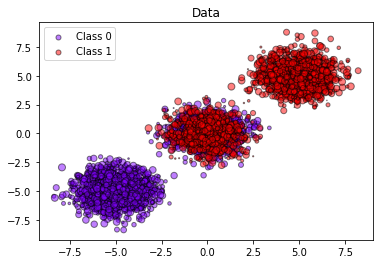

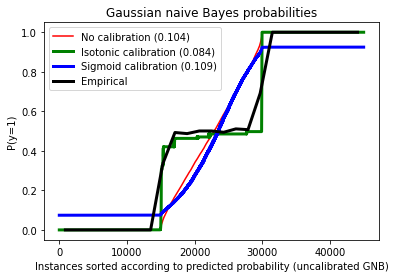

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split


n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42
)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier score losses: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

# #############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf,))
plt.plot(prob_pos_clf[order], "r", label="No calibration (%1.3f)" % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    "g",
    linewidth=3,
    label="Isotonic calibration (%1.3f)" % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    "b",
    linewidth=3,
    label="Sigmoid calibration (%1.3f)" % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    "k",
    linewidth=3,
    label=r"Empirical",
)
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability (uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()